In [1]:
import os
from merlin.datasets.entertainment import get_movielens

input_path = os.environ.get("INPUT_DATA_DIR", os.path.expanduser("~/merlin-framework/movielens/"))
get_movielens(variant="ml-1m", path=input_path); #noqa

/usr/local/lib/python3.8/dist-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")


In [2]:
from merlin.core.dispatch import get_lib

data = get_lib().read_parquet(f'{input_path}ml-1m/train.parquet').sample(frac=1)

train = data.iloc[:600_000]
valid = data.iloc[600_000:]

movies = get_lib().read_parquet(f'{input_path}ml-1m/movies_converted.parquet')

In [3]:
train.head()

,userId,movieId,rating,timestamp
347753,2040,2710,3,974666885
88073,579,2000,5,975977030
676285,4054,1210,5,965505005
767315,4572,1812,3,964462623
152450,981,1147,4,975103599


In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Animation, Children's, Comedy]"
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [5]:
import nvtabular as nvt
from merlin.schema.tags import Tags

train_ds = nvt.Dataset(train, npartitions=2)
valid_ds = nvt.Dataset(valid)

train_ds, valid_ds

(<merlin.io.dataset.Dataset at 0x7fe333a932e0>,
 <merlin.io.dataset.Dataset at 0x7fe333a937f0>)

In [6]:
train_ds.shuffle_by_keys('userId')
valid_ds.shuffle_by_keys('userId')

In [7]:
train_ds.npartitions

2

In [8]:
genres = ['movieId'] >> nvt.ops.JoinExternal(movies, on='movieId', columns_ext=['movieId', 'genres'])

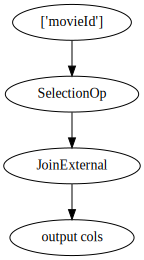

In [9]:
genres.graph

In [10]:
movies['genres'].head()

0     [Animation, Children's, Comedy]
1    [Adventure, Children's, Fantasy]
2                   [Comedy, Romance]
3                     [Comedy, Drama]
4                            [Comedy]
Name: genres, dtype: list

In [11]:
genres = genres >> nvt.ops.Categorify(freq_threshold=10)

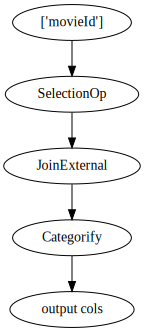

In [12]:
genres.graph

In [13]:
movies['genres'].head()

0     [Animation, Children's, Comedy]
1    [Adventure, Children's, Fantasy]
2                   [Comedy, Romance]
3                     [Comedy, Drama]
4                            [Comedy]
Name: genres, dtype: list

In [14]:
def rating_to_binary(col):
    return col > 3

binary_rating = ['rating'] >> nvt.ops.LambdaOp(rating_to_binary) >> nvt.ops.Rename(name='binary_rating')

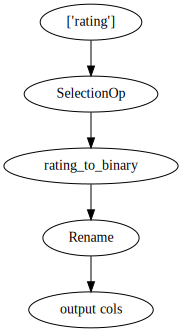

In [15]:
binary_rating.graph

In [16]:
userId = ['userId'] >> nvt.ops.Categorify() >> nvt.ops.AddTags(tags=[Tags.USER_ID, Tags.CATEGORICAL, Tags.USER])
movieId = ['movieId'] >> nvt.ops.Categorify() >> nvt.ops.AddTags(tags=[Tags.ITEM_ID, Tags.CATEGORICAL, Tags.ITEM])
binary_rating = binary_rating >> nvt.ops.AddTags(tags=[Tags.TARGET, Tags.BINARY_CLASSIFICATION])

In [17]:
workflow = nvt.Workflow(userId + movieId + genres + binary_rating)

In [18]:
train_transformed = workflow.fit_transform(train_ds)
valid_transformed = workflow.transform(valid_ds)
valid_transformed.compute().head()

,userId,movieId,genres,binary_rating
0,715,210,"[5, 9, 11, 6]",True
1,420,543,"[5, 3]",True
2,192,1264,[15],False
3,849,1302,[11],True
4,5576,670,[11],True


In [19]:
train_transformed.schema

,name,tags,dtype,is_list,is_ragged,properties.num_buckets,properties.freq_threshold,properties.max_size,properties.cat_path,properties.domain.min,properties.domain.max,properties.domain.name,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension,properties.value_count.min,properties.value_count.max
0,userId,"(Tags.CATEGORICAL, Tags.ID, Tags.USER)","DType(name='int64', element_type=<ElementType....",False,False,NaN,0.0,0.0,.//categories/unique.userId.parquet,0.0,6042.0,userId,6043.0,210.0,NaN,NaN
1,movieId,"(Tags.CATEGORICAL, Tags.ID, Tags.ITEM)","DType(name='int64', element_type=<ElementType....",False,False,NaN,10.0,0.0,.//categories/unique.movieId.parquet,0.0,3105.0,movieId,3106.0,144.0,NaN,NaN
2,genres,(Tags.CATEGORICAL),"DType(name='int64', element_type=<ElementType....",True,True,NaN,10.0,0.0,.//categories/unique.genres.parquet,0.0,20.0,genres,21.0,16.0,0.0,NaN
3,binary_rating,"(Tags.BINARY_CLASSIFICATION, Tags.TARGET)","DType(name='bool', element_type=<ElementType.B...",False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
from transformers4rec.torch import TabularSequenceFeatures
tabular_inputs = TabularSequenceFeatures.from_schema(
        train_transformed.schema,
        embedding_dim_default=128,
        max_sequence_length=20,
        d_output=100,
        aggregation="concat",
        masking="clm"
    )

Hey this is 20
Hety this is 20
Hey this is feature value count None
Hey this is feature value count None
Hey this is feature value count Domain(min=0, max=None, name=None)
Hety this is 20
Hey this is feature value count None
Hey this is feature value count None
Hey this is feature value count Domain(min=0, max=None, name=None)
Hey this is feature value count None


/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
import torch

In [22]:
torch.Size([32, 20])


torch.Size([32, 20])

In [23]:
from transformers4rec.torch import EmbeddingFeatures

In [24]:
em = EmbeddingFeatures.from_schema(train_transformed.schema,
        embedding_dim_default=128,
        max_sequence_length=20,
        d_output=100,
        aggregation="concat",
        masking="clm")

Hety this is 20
Hey this is feature value count None
Hey this is feature value count None
Hey this is feature value count Domain(min=0, max=None, name=None)
Hey this is feature value count None


In [25]:
from transformers4rec.torch.utils import torch_utils

In [27]:
torch_utils.get_output_sizes_from_schema(schema=train_transformed.schema, max_sequence_length=20)

Hety this is 20
Hey this is feature value count None
Hey this is feature value count None
Hey this is feature value count Domain(min=0, max=None, name=None)
Hey this is feature value count None


{'userId': torch.Size([-1]),
 'movieId': torch.Size([-1]),
 'genres': torch.Size([-1, 20]),
 'binary_rating': torch.Size([-1])}

In [28]:
train_transformed.schema

,name,tags,dtype,is_list,is_ragged,properties.num_buckets,properties.freq_threshold,properties.max_size,properties.cat_path,properties.domain.min,properties.domain.max,properties.domain.name,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension,properties.value_count.min,properties.value_count.max
0,userId,"(Tags.CATEGORICAL, Tags.ID, Tags.USER)","DType(name='int64', element_type=<ElementType....",False,False,NaN,0.0,0.0,.//categories/unique.userId.parquet,0.0,6042.0,userId,6043.0,210.0,NaN,NaN
1,movieId,"(Tags.CATEGORICAL, Tags.ID, Tags.ITEM)","DType(name='int64', element_type=<ElementType....",False,False,NaN,10.0,0.0,.//categories/unique.movieId.parquet,0.0,3105.0,movieId,3106.0,144.0,NaN,NaN
2,genres,(Tags.CATEGORICAL),"DType(name='int64', element_type=<ElementType....",True,True,NaN,10.0,0.0,.//categories/unique.genres.parquet,0.0,20.0,genres,21.0,16.0,0.0,NaN
3,binary_rating,"(Tags.BINARY_CLASSIFICATION, Tags.TARGET)","DType(name='bool', element_type=<ElementType.B...",False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
from transformers4rec.torch import TabularFeatures

In [30]:
TabularFeatures.from_schema(schema=train_transformed.schema,
        embedding_dim_default=128,
        max_sequence_length=20,
        d_output=100,
        aggregation="concat",
        masking="clm")

Hey this is 20
Hety this is 20
Hey this is feature value count None
Hey this is feature value count None
Hey this is feature value count Domain(min=0, max=None, name=None)
Hety this is 20
Hey this is feature value count None
Hey this is feature value count None
Hey this is feature value count Domain(min=0, max=None, name=None)
Hey this is feature value count None


TabularFeatures(
  (_aggregation): ConcatFeatures()
  (to_merge): ModuleDict(
    (categorical_module): EmbeddingFeatures(
      (filter_features): FilterFeatures()
      (embedding_tables): ModuleDict(
        (userId): EmbeddingBagWrapper(6043, 128, mode='mean')
        (movieId): EmbeddingBagWrapper(3106, 128, mode='mean')
        (genres): EmbeddingBagWrapper(21, 128, mode='mean')
      )
    )
    (pretrained_embedding_module): PretrainedEmbeddingFeatures(
      (filter_features): FilterFeatures()
    )
  )
)

In [31]:
from transformers4rec.config import transformer
from transformers4rec.torch import MLPBlock, SequentialBlock, TransformerBlock

# Configures the XLNet Transformer architecture.
transformer_config = transformer.XLNetConfig.build(
    d_model=64, n_head=4, n_layer=2, total_seq_length=20
)

# Defines the model body including: inputs, masking, projection and transformer block.
model_body = SequentialBlock(
    tabular_inputs,
    MLPBlock([64]),
    TransformerBlock(transformer_config, masking=tabular_inputs.masking)
)


In [35]:
from transformers4rec.torch import model, Head, NextItemPredictionTask

In [37]:
from transformers4rec import torch as tr
from transformers4rec.torch.ranking_metric import NDCGAt, RecallAt

# Create a schema or read one from disk: tr.Schema().from_json(SCHEMA_PATH).
schema = train_transformed.schema
max_sequence_length, d_model = 20, 64

# Define the input module to process the tabular input features.
input_module = tabular_inputs = TabularSequenceFeatures.from_schema(
        train_transformed.schema,
        embedding_dim_default=128,
        max_sequence_length=20,
        d_output=100,
        aggregation="concat",
        masking="clm"
    )

# Define a transformer-config like the XLNet architecture.
transformer_config = tr.XLNetConfig.build(
    d_model=d_model, n_head=4, n_layer=2, total_seq_length=max_sequence_length
)

# Define the model block including: inputs, masking, projection and transformer block.
body = tr.SequentialBlock(
    input_module,
    tr.MLPBlock([d_model]),
    tr.TransformerBlock(transformer_config, masking=input_module.masking)
)

# Define the evaluation top-N metrics and the cut-offs
metrics = [NDCGAt(top_ks=[20, 40], labels_onehot=True),
           RecallAt(top_ks=[20, 40], labels_onehot=True)]

# Define a head with NextItemPredictionTask.
head = tr.Head(
    body,
    tr.NextItemPredictionTask(weight_tying=True, metrics=metrics),
    inputs=input_module,
)

# Get the end-to-end Model class.
model = tr.Model(head)

Hey this is 20
Hety this is 20
Hey this is feature value count None
Hey this is feature value count None
Hey this is feature value count Domain(min=0, max=None, name=None)
Hety this is 20
Hey this is feature value count None
Hey this is feature value count None
Hey this is feature value count Domain(min=0, max=None, name=None)
Hey this is feature value count None


In [ ]:
schema